In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables
import gc
import gzip
from scipy.sparse import coo_matrix
from sklearn.preprocessing import normalize
import pickle

# Load raw TCCs into memory

In [2]:
# tsvfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/MemoryNaive/TCC_output/matrix.tsv'
# COOinput = pd.read_csv( tsvfile_dir, delimiter='\t',header=None, dtype=int)

# A=COOinput.as_matrix()

# rows,cols,data = A.T

In [3]:
# nonzero_ec = np.unique(rows)
# map_rows = { val:ind for ind,val in enumerate( nonzero_ec ) }
# map_cols = { val:ind for ind,val in enumerate( np.unique(cols) ) }
# TCCmatrix   = coo_matrix( (data.astype(float),( [map_rows[r] for r in rows], [map_cols[c] for c in cols]) ) ) 

# NUM_OF_CELLS = TCCmatrix.shape[1]
# print("NUM_OF_CELLS =", NUM_OF_CELLS)
      
# T = TCCmatrix.tocsr()
# # T_norm = normalize(T, norm='l1', axis=0) 
# # T_normT = T_norm.transpose()

In [4]:

# del TCCmatrix,map_cols,map_rows,A,rows,cols,data;
# _ = gc.collect()

In [5]:
# ecfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/MemoryNaive/TCC_output/matrix.ec'
# eclist=pd.read_csv( ecfile_dir, delimiter='\t',header=None, dtype=str)
# eclist=np.array(eclist)

In [6]:
# cellfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/MemoryNaive/TCC_output/matrix.cells'
# celllist=pd.read_csv( cellfile_dir, delimiter='\t',header=None, dtype=str)
# print(celllist.iloc[123][0][10:-1])

In [7]:
# cellnames=[]
# for i in range(len(celllist.index)):
#     cellnames+=[celllist.iloc[i][0][10:-1]]
# cellnames=np.array(cellnames)

In [8]:
# #Save data
# with open("./TCC_matrix_MNC_0.dat", 'wb') as f:
#     pickle.dump(T,f)
# with open("./nonzero_ec_MNC_0.dat", 'wb') as f:
#     pickle.dump(nonzero_ec,f)
# with open("./eclist_MNC_0.dat", 'wb') as f:
#     pickle.dump(eclist,f)
# with open("./cellnames_MNC_0.dat", 'wb') as f:
#     pickle.dump(cellnames,f)
    


##  Load pickled TCCs

In [9]:
#Load dataset   
with open("./TCC_matrix_MNC_0.dat", 'rb') as f:
    T=pickle.load(f)
with open("./nonzero_ec_MNC_0.dat", 'rb') as f:
    nonzero_ec=pickle.load(f)
with open("./eclist_MNC_0.dat", 'rb') as f:
    eclist=pickle.load(f)
with open("./cellnames_MNC_0.dat", 'rb') as f:
    cellnames=pickle.load(f)
    
# T_norm = normalize(T, norm='l1', axis=0)
# T_normT = T_norm.T   

### quality control

In [10]:
# median umis per cell
print("median UMIs per cell:",np.median(np.array((np.sum(T,axis=0))).reshape(1,-1)[0]))

median UMIs per cell: 5248.0


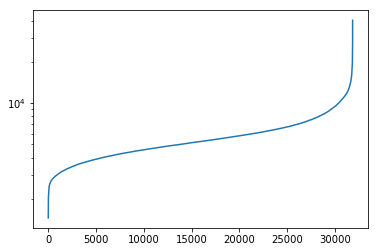

In [11]:
readspercell=np.array((np.sum(T,axis=0))).reshape(1,-1)[0]
plt.semilogy(np.sort(readspercell))

In [12]:
hi_low=[30000,1000]
cells_keep = np.where(readspercell<hi_low[0])[0]
idx = np.where(readspercell[cells_keep]>hi_low[1])[0]
cells_keep=cells_keep[idx]

In [13]:
cellnames = cellnames[cells_keep]

In [14]:
cells_keep.shape

(31831,)

In [15]:
T=T[:,cells_keep]

#### ECdict

In [16]:
EC_dict = {}
for i in range(np.shape(eclist)[0]):
    EC_dict[i] = [int(x) for x in eclist[i,1].split(',')]
    
union=set()
for i in nonzero_ec:
    new = [tx for tx in EC_dict[i] if tx not in union] # filter out previously seen transcripts
    union.update(new) 
union_list=np.sort(list(union)) #union of all transctipt ids seen in nonzero eq.classes
NUM_OF_TX_inTCC = len(union)
print("NUM_OF_Transcripts =", NUM_OF_TX_inTCC) #number of distinct transcripts in nonzero eq. classes 

NUM_OF_Transcripts = 133211


In [17]:
path_to_ref='/home/vasilis/clustering_EQ/Human_reference/Homo_sapiens.GRCh38.rel79.cdna.all.fa.gz'

def readENS_ids(path_to_ref):
    TX_to_ENST={}
    TX_to_ENSG={}
    ENSG_isoforms={}
    line_cnt=0;
    tx_cnt=0;
    with gzip.open(path_to_ref) as f:
        for line in f:
            if line.decode('UTF-8')[0]=='>':
                liner=line.decode('UTF-8')
                if line_cnt == union_list[tx_cnt]:
                    TX_to_ENST[union_list[tx_cnt]] = 'ENST'+liner.split("ENST",1)[1][:11]
                    TX_to_ENSG[union_list[tx_cnt]] = 'ENSG'+liner.split("ENSG",1)[1][:11]
                    ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]] = ENSG_isoforms.get(TX_to_ENSG[union_list[tx_cnt]], [])
                    ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]].append(TX_to_ENST[union_list[tx_cnt]])
                    tx_cnt+=1 
                    if tx_cnt==NUM_OF_TX_inTCC: return [TX_to_ENST,TX_to_ENSG,ENSG_isoforms]
                line_cnt+=1
    return [TX_to_ENST,TX_to_ENSG,ENSG_isoforms]


[TX_to_ENST,TX_to_ENSG,ENSG_isoforms]=readENS_ids(path_to_ref)       

In [18]:
EC_ENST_DICT={}
EC_ENSG_DICT={}
for ec in nonzero_ec:
    EC_ENST_DICT[ec] = [TX_to_ENST[tx] for tx in EC_dict[ec]]    
    EC_ENSG_DICT[ec] = list(np.unique([TX_to_ENSG[tx] for tx in EC_dict[ec]])) 

In [19]:
ENST_to_TX = {v: k for k, v in TX_to_ENST.items()}

In [20]:
#inv_map ; NOTE: genes and transcripts may be associated with multiple ensg accession numbers
ENSG_EC_DICT={}
for k, v in EC_ENSG_DICT.items():
    for vi in v:
        ENSG_EC_DICT[vi] = ENSG_EC_DICT.get(vi, [])
        ENSG_EC_DICT[vi].append(k)
        
ENST_EC_DICT={}
for k, v in EC_ENST_DICT.items():
    for vi in v:
        ENST_EC_DICT[vi] = ENST_EC_DICT.get(vi, [])
        ENST_EC_DICT[vi].append(k)

In [21]:
all_genes_ids = np.unique(list(TX_to_ENSG.values()))
print("NUM_OF_GENE_IDs =", len(all_genes_ids))

NUM_OF_GENE_IDs = 25940


In [22]:
clean_gene_ids=[]

for gene in all_genes_ids:
    if len(list(np.unique([EC_ENSG_DICT[ec] for ec in ENSG_EC_DICT[gene]]))) == 1:
        clean_gene_ids+=[gene]
clean_gene_ids=np.array(clean_gene_ids)

In [23]:
print("NUM_OF_CLEAN_GENE_IDs =", len(clean_gene_ids))

NUM_OF_CLEAN_GENE_IDs = 6234


#### gene names

In [24]:
# #gene ids to gene names (requires "pip install mygene")
# import mygene
# mg = mygene.MyGeneInfo()
# ginfo = mg.querymany(all_genes_ids, scopes='ensembl.gene',returnall=True)

# with open('ginfo_MNC_0.pickle', 'wb') as handle:
#     pickle.dump(ginfo, handle, protocol=pickle.HIGHEST_PROTOCOL)

#LOAD
with open('./ginfo_MNC_0.pickle', 'rb') as handle:
    ginfo = pickle.load(handle)

In [25]:
missing_names=ginfo['missing']
duplicate_names=ginfo['dup']

In [26]:
#ENSG to Gene-Names
all_gene_id_to_names={} #missing are mapped to their ENSG id, Duplicates to a list of names
count_exept=0
for g in ginfo['out']:
    try:
        ensg_id=str(g['query'])
        all_gene_id_to_names[ensg_id] = all_gene_id_to_names.get(ensg_id, [])
        all_gene_id_to_names[ ensg_id].append(str(g['symbol']))                
    except KeyError:
        count_exept=count_exept+1
        all_gene_id_to_names[ str(g['query']) ] = [str(g['query'])]
        
#Gene-Names to ENSG
all_gene_names_to_id={} #missing are mapped to their ENSG id, Duplicates to a list of names
count_exept=0
for g in ginfo['out']:
    try:
        gene_name=str(g['symbol'])
        all_gene_names_to_id[gene_name] = all_gene_names_to_id.get(gene_name, [])
        all_gene_names_to_id[ gene_name].append(str(g['query']))                
    except KeyError:
        count_exept=count_exept+1
        all_gene_names_to_id[ str(g['query']) ] = [str(g['query'])]

In [27]:
def search_gene(starting_letters):
    print("SEARCHING: ",starting_letters,"...")
    for gene in all_genes_ids:
        if all_gene_id_to_names[gene][0][:len(starting_letters)] == starting_letters:
            print(gene,all_gene_id_to_names[gene])
    print("DONE")

In [28]:
EC_IDX={}
for i in range(len(nonzero_ec)):
    EC_IDX[nonzero_ec[i]] =i 

# PTPRC

In [29]:
gene="PTPRC"
all_gene_names_to_id[gene]

['ENSG00000081237', 'ENSG00000262418']

In [30]:
gene_ecs0=[]
for g in all_gene_names_to_id[gene]:
    gene_ecs0+=ENSG_EC_DICT[g]
gene_ecs0=np.unique(gene_ecs0)

In [31]:
gene_ecs0

array([185825, 199819, 211359, 224159, 232661, 238957, 246503, 247023,
       250045, 250930, 252809, 260768, 274831, 288014, 297171, 314713,
       330776, 364464, 428740, 512155, 572140, 577209, 599451, 599452,
       599453, 615875, 656355, 658929, 658930, 658931, 658932, 658933,
       689589, 712829, 713742, 715513, 722147, 745938])

In [32]:
ec_counts=[]
for ec in gene_ecs0:
    ec_counts+=[T[EC_IDX[ec],:].sum()]
ec_nnz_cell_counts=[]
for ec in gene_ecs0:
    ec_nnz_cell_counts+=[T[EC_IDX[ec],:].nnz] 
    

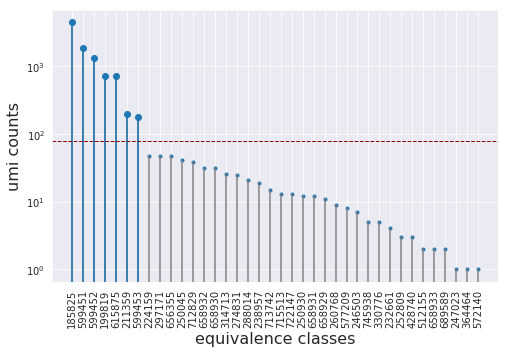

In [33]:
sns.set_style("darkgrid")

threshold=0.0025*T.shape[1]

gene_ecs=gene_ecs0[np.where(np.array(ec_counts)>threshold)[0]]
upto=len(gene_ecs)

plt.figure(figsize=(8,5))
plt.stem(range(len(ec_counts)),np.sort(ec_counts)[::-1],'gray',markerfmt='.')

plt.xticks(range(len(ec_counts)),gene_ecs0[np.argsort(ec_counts)[::-1]],rotation='vertical')
# plt.xlim([0,len(b)+0.9])

plt.stem(range(upto),np.sort(ec_counts)[::-1][:upto])

plt.axhline(y=threshold, color='darkred', linestyle='--',linewidth=1)
plt.xlabel("equivalence classes",fontsize=16)
plt.ylabel("umi counts",fontsize=16)
plt.yscale('log')
plt.show()

In [34]:
print(gene_ecs)

[185825 199819 211359 599451 599452 599453 615875]


In [35]:
associated_genes=[]
for ec in gene_ecs:
    associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
associated_genes=np.unique(associated_genes)
print(associated_genes)

['PTPRC']


In [36]:
ecidx=np.array([EC_IDX[ec] for ec in gene_ecs])

In [37]:
ecidx

array([ 62333,  69896,  76094, 214260, 214261, 214262, 223213])

In [38]:
eq_classes=[]
for i in ecidx:
    tx_indices=EC_dict[nonzero_ec[i]]
    tx_ens=[TX_to_ENST[t] for t in tx_indices]
    eq_classes+=[tx_ens]

In [39]:
import json
eq_dict={}
for i in range(len(eq_classes)):
    eq_dict[str(ecidx[i])] = list(np.sort(eq_classes[i]))
print(json.dumps(eq_dict, indent=1))

{
 "62333": [
  "ENST00000348564",
  "ENST00000442510"
 ],
 "69896": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000442510",
  "ENST00000529828",
  "ENST00000530727",
  "ENST00000573477",
  "ENST00000573679",
  "ENST00000574441",
  "ENST00000575923",
  "ENST00000576833"
 ],
 "76094": [
  "ENST00000413409",
  "ENST00000571847"
 ],
 "214260": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000442510",
  "ENST00000529828"
 ],
 "214261": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000442510",
  "ENST00000529828",
  "ENST00000530727"
 ],
 "214262": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000442510",
  "ENST00000491302",
  "ENST00000529828",
  "ENST00000530727",
  "ENST00000573477",
  "ENST00000573679",
  "ENST00000574441",
  "ENST00000575803",
  "ENST00000575923",
  "ENST00000576833"
 ],
 "223213": [
  "ENST00000348564",
  "ENST00000367367",
  "ENST00000367379",
  "ENST00000442510",
  "ENST00000529828",
  "ENST00000530727",
  "ENST00000573298",
  "ENST000

# LogR

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import math

In [41]:
labels=[]
for name in cellnames:
    if name[-1]=='N':
        labels+=[0]
    elif name[-1]=='M':
        labels+=[1]
    else:
        labels+=[2]
labels=np.array(labels)

In [42]:
def logr_ecidx(ecidx,X1,X2):
    
    N1=X1.shape[0]
    N2=X2.shape[0]
    logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
    logr = LogisticRegression()
    p_of_1=N1/float(N1+N2)
    llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
    k=len(ecidx)
    
    X1_ecidx=X1[:,ecidx].todense()
    X2_ecidx=X2[:,ecidx].todense()
    c=np.concatenate([X1_ecidx,X2_ecidx])
    #c=np.concatenate([X1[:,ecidx],X2[:,ecidx]])
    logr.fit(c,logr_labels)
    pred=np.array(logr.predict_proba(c)[:,1])
    gene_score=log_loss(logr_labels,pred)
    llf=-gene_score*(N1+N2)
    llr=llf-llnull
    llr_pval = 1-stats.chi2.cdf(2*llr,k)
    
    return [logr,llr_pval]

In [43]:
X=T.T

In [44]:
X_naive=X[np.squeeze(labels==0),:]
X_mem=X[np.squeeze(labels==1),:]
X_cyto=X[np.squeeze(labels==2),:]




print("naive cells: ",X_naive.shape[0])
print("mem cells: ",X_mem.shape[0])
print("cyto cells: ",X_cyto.shape[0])

naive cells:  9923
mem cells:  9994
cyto cells:  11914


In [45]:
np.random.seed(0)
samples=3000

randperm1=np.random.permutation(X_naive.shape[0])
randperm2=np.random.permutation(X_mem.shape[0])
randperm3=np.random.permutation(X_cyto.shape[0])

In [46]:
sns.set_style("white")

(3000, 342638)
(3000, 342638)
pval= 9.16495524228e-06


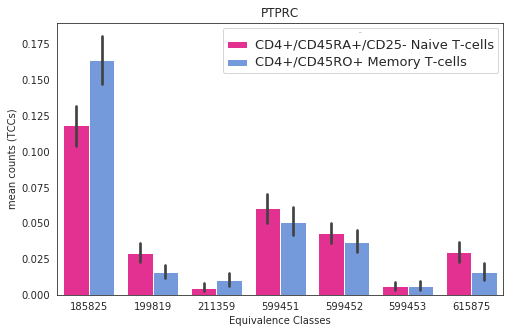

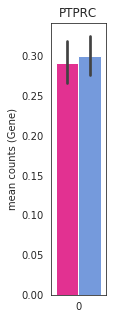

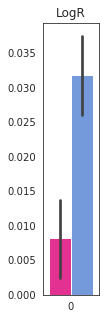

In [47]:
#positive control 

X1=X_naive[randperm1[:samples],:]
X2=X_mem[randperm2[:samples],:]


print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()


E_naive_mean = np.array(np.mean(X1[:,ecidx],axis=0))[0]
E_mem_mean = np.array(np.mean(X2[:,ecidx],axis=0))[0]

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

G_naive_mean = np.mean(Gexp1)
G_mem_mean = np.mean(Gexp2)

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()


A1=np.array(np.dot(X1_ecidx,-A[0].coef_[0]))[0]
A2=np.array(np.dot(X2_ecidx,-A[0].coef_[0]))[0]

P1=pd.DataFrame(A1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(A2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='', ylabel='')
ax.legend_.remove()
plt.title("LogR")
plt.show()


Optimization terminated successfully.
         Current function value: 0.690189
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5992
Method:                           MLE   Df Model:                            7
Date:                Mon, 05 Nov 2018   Pseudo R-squ.:                0.004268
Time:                        15:52:05   Log-Likelihood:                -4141.1
converged:                       True   LL-Null:                       -4158.9
                                        LLR p-value:                 9.017e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0202      0.028      0.721      0.471      -0.035       0.075
x1            -0.2542      0.

<Container object of 3 artists>

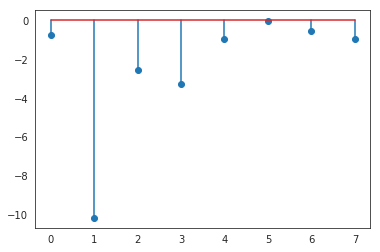

In [48]:
N1=X1.shape[0]
N2=X2.shape[0]
logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)

X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()
c=np.concatenate([X1_ecidx,X2_ecidx])
c=np.concatenate([np.ones((N1+N2,1)),c],axis=1)
logit = sm.Logit( logr_labels,c)


# fit the model
result = logit.fit()
print( result.summary())
print(result.wald_test_terms())
plt.stem(np.log(result.pvalues))

(3000, 342638)
(3000, 342638)
pval= 0.721686604101


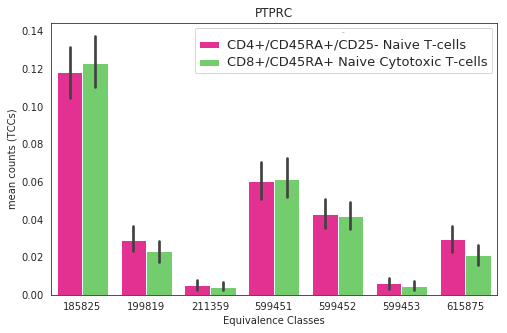

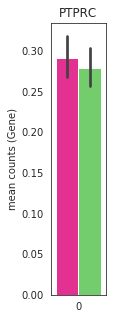

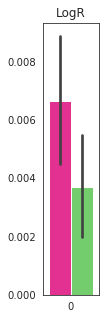

In [49]:
#negative control 

X1=X_naive[randperm1[:samples],:]
X2=X_cyto[randperm3[:samples],:]


print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()


E_cyto_mean = np.array(np.mean(X2[:,ecidx],axis=0))[0]

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

G_cyto_mean = np.mean(Gexp2)

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()


A1=np.array(np.dot(X1_ecidx,A[0].coef_[0]))[0]
A2=np.array(np.dot(X2_ecidx,A[0].coef_[0]))[0]

P1=pd.DataFrame(A1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(A2.T)
P2['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')


plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='', ylabel='')
ax.legend_.remove()
plt.title("LogR")
plt.show()

Optimization terminated successfully.
         Current function value: 0.692772
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5992
Method:                           MLE   Df Model:                            7
Date:                Mon, 05 Nov 2018   Pseudo R-squ.:               0.0005414
Time:                        15:52:08   Log-Likelihood:                -4156.6
converged:                       True   LL-Null:                       -4158.9
                                        LLR p-value:                    0.7203
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0054      0.028     -0.193      0.847      -0.060       0.049
x1            -0.0283      0.

<Container object of 3 artists>

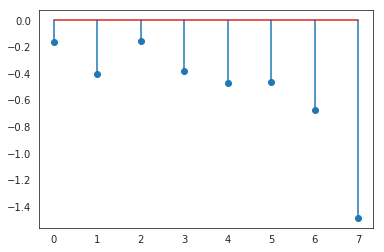

In [50]:
N1=X1.shape[0]
N2=X2.shape[0]
logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)

X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()
c=np.concatenate([X1_ecidx,X2_ecidx])
c=np.concatenate([np.ones((N1+N2,1)),c],axis=1)
logit = sm.Logit( logr_labels,c)


# fit the model
result = logit.fit()
print( result.summary())
print(result.wald_test_terms())
plt.stem(np.log(result.pvalues))

(3000, 342638)
(3000, 342638)
pval= 0.000279477161797


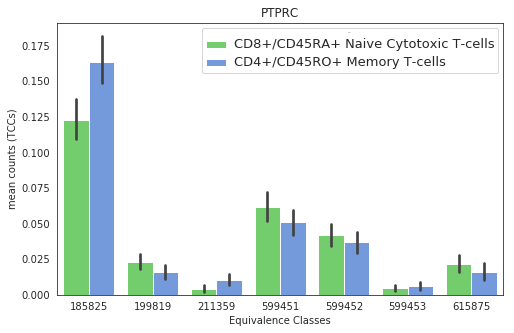

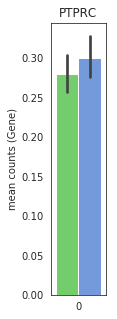

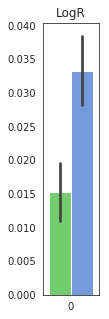

In [51]:
#positive control 

X1=X_cyto[randperm3[:samples],:]
X2=X_mem[randperm2[:samples],:]



print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c","#6495ED"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c","#6495ED"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()


A1=np.array(np.dot(X1_ecidx,-A[0].coef_[0]))[0]
A2=np.array(np.dot(X2_ecidx,-A[0].coef_[0]))[0]

P1=pd.DataFrame(A1.T,)
P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P2=pd.DataFrame(A2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')


plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c","#6495ED"], data=df)
ax.set(xlabel='', ylabel='')
ax.legend_.remove()
plt.title("LogR")
plt.show()

Optimization terminated successfully.
         Current function value: 0.690856
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5992
Method:                           MLE   Df Model:                            7
Date:                Mon, 05 Nov 2018   Pseudo R-squ.:                0.003305
Time:                        15:52:11   Log-Likelihood:                -4145.1
converged:                       True   LL-Null:                       -4158.9
                                        LLR p-value:                 0.0002715
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0243      0.028      0.864      0.388      -0.031       0.079
x1            -0.2274      0.

<Container object of 3 artists>

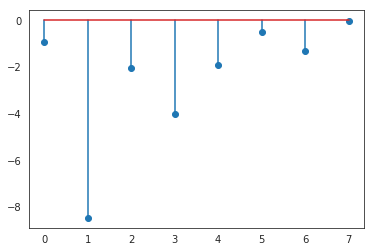

In [52]:
N1=X1.shape[0]
N2=X2.shape[0]
logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)

X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()
c=np.concatenate([X1_ecidx,X2_ecidx])
c=np.concatenate([np.ones((N1+N2,1)),c],axis=1)
logit = sm.Logit( logr_labels,c)


# fit the model
result = logit.fit()
print( result.summary())
print(result.wald_test_terms())
plt.stem(np.log(result.pvalues))

In [53]:
from scipy.stats import ttest_ind

def ttest_ecidx(ecidx,X1,X2):
    
    N1=X1.shape[0]
    N2=X2.shape[0]
    logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
    
    k=len(ecidx)
    
    X1_ecidx=X1[:,ecidx].todense()
    X2_ecidx=X2[:,ecidx].todense()
    
    pvals=[]
    for j in range(k):
        a=X1_ecidx[:,j]
        b=X2_ecidx[:,j]
        [o,p]=ttest_ind(a,b,equal_var=False)
        pvals+=[p]
    pval=np.min([1,np.min(np.array(pvals))*k])
    g1=np.sum(X1_ecidx,axis=1)
    g2=np.sum(X2_ecidx,axis=1)
    [o,gene_pval]=ttest_ind(g1,g2,equal_var=False)
    all_pvals=np.array([np.min([1,k*p]) for p in pvals])
    return pval,all_pvals,gene_pval[0]


def logr_gene(ecidx,X1,X2):
    
    N1=X1.shape[0]
    N2=X2.shape[0]
    logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
    logr = LogisticRegression()
    p_of_1=N1/float(N1+N2)
    llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
  
    k=1
    
    X1_ecidx=X1[:,ecidx].todense()
    X2_ecidx=X2[:,ecidx].todense()
    
    g1=np.sum(X1_ecidx,axis=1)
    g2=np.sum(X2_ecidx,axis=1)
    
    c=np.concatenate([g1,g2])
    logr.fit(c,logr_labels)
    pred=np.array(logr.predict_proba(c)[:,1])
    gene_score=log_loss(logr_labels,pred)
    llf=-gene_score*(N1+N2)
    llr=llf-llnull
    llr_pval = 1-stats.chi2.cdf(2*llr,k)
    
    return [logr,llr_pval]


def logr_indep(ecidx,X1,X2):
    pvals_tmp=[]
    for j in ecidx:
        B=logr_ecidx([j],X1,X2)
        pvals_tmp+=[B[1]]
    pval_sep=np.min([1,np.min(np.array(pvals_tmp))*len(ecidx)])
    all_pvals=np.array([np.min([1,p*len(ecidx)]) for p in pvals_tmp])
    
    return [all_pvals,pval_sep]

In [54]:
print('--------mem/naive----------')
X1=X_naive[randperm1[:samples],:]
X2=X_mem[randperm2[:samples],:]
aA1=logr_ecidx(ecidx,X1,X2)
bB1=logr_gene(ecidx,X1,X2)
cC1=logr_indep(ecidx,X1,X2)
print('-log10_GENE-pval=',-np.log10(bB1[1]))
print('-log10_LOGR-pval=',-np.log10(aA1[1]))
print('-log10_INDT-pval_min=',-np.log10(cC1[1]))
print('-log10_INDT-pvals=\n',-np.log10(cC1[0]))

print('--------cyto/mem----------')
X1=X_cyto[randperm3[:samples],:]
X2=X_mem[randperm2[:samples],:]
aA2=logr_ecidx(ecidx,X1,X2)
bB2=logr_gene(ecidx,X1,X2)
cC2=logr_indep(ecidx,X1,X2)
print('-log10_GENE-pval=',-np.log10(bB2[1]))
print('-log10_LOGR-pval=',-np.log10(aA2[1]))
print('-log10_INDT-pval_min=',-np.log10(cC2[1]))
print('-log10_INDT-pvals=\n',-np.log10(cC2[0]))

print('--------naive/cyto----------')
X1=X_naive[randperm1[:samples],:]
X2=X_cyto[randperm3[:samples],:]
aA3=logr_ecidx(ecidx,X1,X2)
bB3=logr_gene(ecidx,X1,X2)
cC3=logr_indep(ecidx,X1,X2)
print('-log10_GENE-pval=',-np.log10(bB3[1]))
print('-log10_LOGR-pval=',-np.log10(aA3[1]))
print('-log10_INDT-pval_min=',-np.log10(cC3[1]))
print('-log10_INDT-pvals=\n',-np.log10(cC3[0]))

--------mem/naive----------
-log10_GENE-pval= 0.18785945293
-log10_LOGR-pval= 5.03786965161
-log10_INDT-pval_min= 3.49600728797
-log10_INDT-pvals=
 [ 3.49600729  2.08457768  0.6778492  -0.         -0.         -0.
  1.66164603]
--------cyto/mem----------
-log10_GENE-pval= 0.605083243201
-log10_LOGR-pval= 3.55365367583
-log10_INDT-pval_min= 2.75675369807
-log10_INDT-pvals=
 [ 2.7567537   0.3816539   1.06005474  0.00644869 -0.         -0.         -0.        ]
--------naive/cyto----------
-log10_GENE-pval= 0.299542855175
-log10_LOGR-pval= 0.141651355973
-log10_INDT-pval_min= 0.322907578562
-log10_INDT-pvals=
 [-0.         -0.         -0.         -0.         -0.         -0.
  0.32290758]


### Mem-Naive

In [55]:
np.random.seed(0)
samples=3000
carlo=200
pvals=[]
pvals_t_test=[]
pvals_sep_logR=[]
pvals_t_test_gene=[]
pvals_logr_gene=[]
for monte in range(carlo):
    randperm1A=np.random.permutation(X_naive.shape[0])
    randperm2A=np.random.permutation(X_mem.shape[0])
    #positive control 

    X1=X_naive[randperm1A[:samples],:]
    X2=X_mem[randperm2A[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    
    pvals+=[A[1]]
    tpval=ttest_ecidx(ecidx,X1,X2)
    pvals_t_test+=[tpval[0]]
    pvals_t_test_gene+=[tpval[2]]
    
    Ag=logr_gene(ecidx,X1,X2)
    pvals_logr_gene+=[Ag[1]]
    
    
    
    
    pvals_tmp=[]
    for j in ecidx:
        B=logr_ecidx([j],X1,X2)
        pvals_tmp+=[B[1]]
    pval_sep=np.min([1,np.min(np.array(pvals_tmp))*len(ecidx)])
    pvals_sep_logR+=[pval_sep]
    
    print(monte,'\t logr pval=',A[1],'\t sepLR pval=',pval_sep,'\t gene pval=',Ag[1])
    
    
print("\n logR Avg. p-value: ",np.mean(pvals))
print("\n seplogR Avg. p-value: ",np.mean(pvals_sep_logR))
print("\n gene Avg. p-value: ",np.mean(pvals_logr_gene))

0 	 logr pval= 9.16495524228e-06 	 sepLR pval= 0.000319148429779 	 gene pval= 0.648844379623
1 	 logr pval= 9.13170923578e-06 	 sepLR pval= 5.83746445515e-07 	 gene pval= 0.021772128785
2 	 logr pval= 0.000148094002777 	 sepLR pval= 0.00320678007969 	 gene pval= 0.478495587257
3 	 logr pval= 0.000429046499225 	 sepLR pval= 0.00763794596729 	 gene pval= 0.746753980203
4 	 logr pval= 5.17134131406e-07 	 sepLR pval= 1.0486494525e-06 	 gene pval= 0.447571019378
5 	 logr pval= 0.130618082316 	 sepLR pval= 0.377871204256 	 gene pval= 0.733042039003
6 	 logr pval= 5.00753412069e-08 	 sepLR pval= 1.66550985958e-05 	 gene pval= 0.250225521813
7 	 logr pval= 0.000316304960972 	 sepLR pval= 0.0105580870864 	 gene pval= 0.851440893018
8 	 logr pval= 0.0308109939978 	 sepLR pval= 0.0216296145039 	 gene pval= 0.440758273738
9 	 logr pval= 0.0004694632142 	 sepLR pval= 0.00949098373315 	 gene pval= 0.460451546417
10 	 logr pval= 0.00348643181666 	 sepLR pval= 0.00537606408993 	 gene pval= 0.424468923

89 	 logr pval= 0.0263482953589 	 sepLR pval= 0.111364587151 	 gene pval= 0.882571060242
90 	 logr pval= 1.41982338631e-06 	 sepLR pval= 0.00103365843661 	 gene pval= 0.974433673963
91 	 logr pval= 1.15194971295e-06 	 sepLR pval= 0.000144965008518 	 gene pval= 0.103201100892
92 	 logr pval= 0.00414296836762 	 sepLR pval= 0.0285484197325 	 gene pval= 0.574903517486
93 	 logr pval= 0.000472571894866 	 sepLR pval= 0.00281036079483 	 gene pval= 0.207346831911
94 	 logr pval= 0.0036964020036 	 sepLR pval= 0.0110371995128 	 gene pval= 0.402238579996
95 	 logr pval= 1.0084050957e-05 	 sepLR pval= 6.14576779161e-05 	 gene pval= 0.43179395465
96 	 logr pval= 7.06989136936e-05 	 sepLR pval= 0.00186724276373 	 gene pval= 0.218692876787
97 	 logr pval= 0.00273156048164 	 sepLR pval= 0.0149246943374 	 gene pval= 0.587222539499
98 	 logr pval= 0.000383280953541 	 sepLR pval= 0.0160333713028 	 gene pval= 0.779706705354
99 	 logr pval= 0.00520800369818 	 sepLR pval= 0.00199656292543 	 gene pval= 0.038

177 	 logr pval= 0.00042914406326 	 sepLR pval= 0.00158122079981 	 gene pval= 0.8126858424
178 	 logr pval= 8.36083206183e-05 	 sepLR pval= 0.0009953447146 	 gene pval= 0.66151254961
179 	 logr pval= 0.00238819850769 	 sepLR pval= 0.0431416533099 	 gene pval= 0.849832599208
180 	 logr pval= 6.98999083282e-07 	 sepLR pval= 1.02128756949e-05 	 gene pval= 0.45701244697
181 	 logr pval= 0.000299230177391 	 sepLR pval= 0.00214306342158 	 gene pval= 0.138725329957
182 	 logr pval= 0.00109735706098 	 sepLR pval= 0.000579880591184 	 gene pval= 0.332917718878
183 	 logr pval= 0.000408901537191 	 sepLR pval= 0.00125666477454 	 gene pval= 0.193386879426
184 	 logr pval= 0.000280939481283 	 sepLR pval= 0.00289753337145 	 gene pval= 0.171274215666
185 	 logr pval= 2.02489584862e-05 	 sepLR pval= 1.52230498207e-06 	 gene pval= 0.0514848882508
186 	 logr pval= 2.05708495049e-06 	 sepLR pval= 0.000772364454817 	 gene pval= 0.732918199439
187 	 logr pval= 1.97221433854e-05 	 sepLR pval= 0.0001623033533

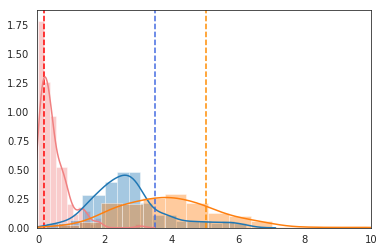

In [56]:
pvals_t_test1=pvals_t_test
pvals_sep_logR1=pvals_sep_logR
pvals1=pvals

plt.figure()
pvals_t_test_gene1=pvals_t_test_gene
pvals_logr_gene1=pvals_logr_gene
# sns.distplot(-np.log10(pvals_t_test_gene1),hist=True,color='r')
ax=sns.distplot(-np.log10(pvals_t_test_gene1),hist=True,color='lightcoral',)

sns.distplot(-np.log10(pvals_sep_logR1))
sns.distplot(-np.log10(pvals1))
# sns.distplot(-np.log10(pvals_t_test1),hist=False,color='k')


yy=ax.get_ylim()
plt.vlines(-np.log10(bB1[1]),ymin=yy[0],ymax=yy[1],color='r',linestyles='--')
plt.vlines(-np.log10(cC1[1]),ymin=yy[0],ymax=yy[1],color='royalblue',linestyles='--')
plt.vlines(-np.log10(aA1[1]),ymin=yy[0],ymax=yy[1],color='darkorange',linestyles='--')

plt.ylim(yy)
plt.xlim([-0.05,10])

plt.show()

### Cyto-Mem

In [57]:
np.random.seed(0)
samples=3000
carlo=200
pvals=[]
pvals_t_test=[]
pvals_sep_logR=[]
for monte in range(carlo):
    randperm1A=np.random.permutation(X_cyto.shape[0])
    randperm2A=np.random.permutation(X_mem.shape[0])
    #positive control 

    X1=X_cyto[randperm1A[:samples],:]
    X2=X_mem[randperm2A[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    
    pvals+=[A[1]]
    tpval=ttest_ecidx(ecidx,X1,X2)
    pvals_t_test+=[tpval[0]]
    pvals_t_test_gene+=[tpval[2]]
    
    Ag=logr_gene(ecidx,X1,X2)
    pvals_logr_gene+=[Ag[1]]
    
    
    
    
    pvals_tmp=[]
    for j in ecidx:
        B=logr_ecidx([j],X1,X2)
        pvals_tmp+=[B[1]]
    pval_sep=np.min([1,np.min(np.array(pvals_tmp))*len(ecidx)])
    pvals_sep_logR+=[pval_sep]
    
    print(monte,'\t logr pval=',A[1],'\t sepLR pval=',pval_sep,'\t gene pval=',Ag[1])
    
    
print("\n logR Avg. p-value: ",np.mean(pvals))
print("\n seplogR Avg. p-value: ",np.mean(pvals_sep_logR))
print("\n gene Avg. p-value: ",np.mean(pvals_logr_gene))

0 	 logr pval= 2.7329784812e-05 	 sepLR pval= 0.000609626570837 	 gene pval= 0.222188366933
1 	 logr pval= 0.00129116845909 	 sepLR pval= 0.00468769789242 	 gene pval= 0.0559887164623
2 	 logr pval= 0.000521702483422 	 sepLR pval= 0.00235780804015 	 gene pval= 0.303842208609
3 	 logr pval= 2.04984977004e-06 	 sepLR pval= 0.000120073826321 	 gene pval= 0.246102822612
4 	 logr pval= 1.41181811797e-08 	 sepLR pval= 5.86117619783e-06 	 gene pval= 0.287367946938
5 	 logr pval= 0.0096978334312 	 sepLR pval= 0.00428961934134 	 gene pval= 0.681366508482
6 	 logr pval= 1.07610502509e-07 	 sepLR pval= 2.36275675491e-06 	 gene pval= 0.0412535941716
7 	 logr pval= 0.000188532329811 	 sepLR pval= 0.0023076874539 	 gene pval= 0.0293299230759
8 	 logr pval= 0.000316623473745 	 sepLR pval= 0.00102663475403 	 gene pval= 0.512911534916
9 	 logr pval= 0.0181693986214 	 sepLR pval= 0.065848023231 	 gene pval= 0.219318730931
10 	 logr pval= 4.50927284343e-05 	 sepLR pval= 0.00333555688988 	 gene pval= 0.01

89 	 logr pval= 7.43763601263e-07 	 sepLR pval= 1.11514091472e-05 	 gene pval= 0.0462672220451
90 	 logr pval= 3.27304664548e-05 	 sepLR pval= 0.000123524540845 	 gene pval= 0.0343817429853
91 	 logr pval= 8.21156764808e-09 	 sepLR pval= 9.91596266176e-06 	 gene pval= 0.098097875174
92 	 logr pval= 0.0132442446898 	 sepLR pval= 0.0588827377827 	 gene pval= 0.46097242037
93 	 logr pval= 3.29507531571e-06 	 sepLR pval= 0.000316357774972 	 gene pval= 0.0614870903723
94 	 logr pval= 0.00130964040671 	 sepLR pval= 0.0242227724617 	 gene pval= 0.0050999229343
95 	 logr pval= 0.0297709106455 	 sepLR pval= 0.0318065854031 	 gene pval= 0.418880320377
96 	 logr pval= 0.00666685373869 	 sepLR pval= 0.0422664274372 	 gene pval= 0.095485134471
97 	 logr pval= 0.0241414396111 	 sepLR pval= 0.0176701978305 	 gene pval= 0.0213334411176
98 	 logr pval= 4.63172639792e-05 	 sepLR pval= 0.00118884871294 	 gene pval= 0.163753309174
99 	 logr pval= 0.00686722357778 	 sepLR pval= 0.0413659665365 	 gene pval=

177 	 logr pval= 0.00243535943629 	 sepLR pval= 0.0095472609835 	 gene pval= 0.0210569378282
178 	 logr pval= 0.00509023693556 	 sepLR pval= 0.00399170076464 	 gene pval= 0.308001868023
179 	 logr pval= 4.93007758792e-05 	 sepLR pval= 0.000505434750909 	 gene pval= 0.192643608777
180 	 logr pval= 0.000821793521376 	 sepLR pval= 0.0488300472898 	 gene pval= 0.0705265169045
181 	 logr pval= 0.000269351840782 	 sepLR pval= 0.00331236358921 	 gene pval= 0.00499212609565
182 	 logr pval= 6.68356931799e-07 	 sepLR pval= 1.93686801312e-05 	 gene pval= 0.803875942592
183 	 logr pval= 0.000707114313311 	 sepLR pval= 0.000139083991411 	 gene pval= 0.028859306272
184 	 logr pval= 2.05334293243e-05 	 sepLR pval= 9.91542741584e-05 	 gene pval= 0.832764228326
185 	 logr pval= 0.0115930343781 	 sepLR pval= 0.00329934820836 	 gene pval= 0.808140439877
186 	 logr pval= 0.000834688380972 	 sepLR pval= 0.0221357977841 	 gene pval= 0.88675105535
187 	 logr pval= 0.00502241717186 	 sepLR pval= 0.0140396819

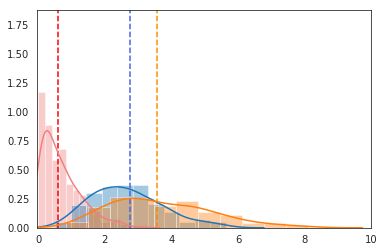

In [58]:
pvals_t_test2=pvals_t_test
pvals_sep_logR2=pvals_sep_logR
pvals2=pvals

plt.figure()
pvals_t_test_gene2=pvals_t_test_gene
pvals_logr_gene2=pvals_logr_gene
# sns.distplot(-np.log10(pvals_t_test_gene2),hist=True,color='r')
sns.distplot(-np.log10(pvals_t_test_gene2),hist=True,color='lightcoral',)

sns.distplot(-np.log10(pvals_sep_logR2))
sns.distplot(-np.log10(pvals2))
# sns.distplot(-np.log10(pvals_t_test2),hist=False,color='k')


yy=ax.get_ylim()
plt.vlines(-np.log10(bB2[1]),ymin=yy[0],ymax=yy[1],color='r',linestyles='--')
plt.vlines(-np.log10(cC2[1]),ymin=yy[0],ymax=yy[1],color='royalblue',linestyles='--')
plt.vlines(-np.log10(aA2[1]),ymin=yy[0],ymax=yy[1],color='darkorange',linestyles='--')

plt.ylim(yy)
plt.xlim([-0.05,10])

plt.show()

### Naive-Cyto

In [59]:
np.random.seed(0)
samples=3000
carlo=200
pvals=[]
pvals_t_test=[]
pvals_sep_logR=[]
for monte in range(carlo):
    randperm1A=np.random.permutation(X_naive.shape[0])
    randperm2A=np.random.permutation(X_cyto.shape[0])
    #positive control 

    X1=X_naive[randperm1A[:samples],:]
    X2=X_cyto[randperm2A[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    
    pvals+=[A[1]]
    tpval=ttest_ecidx(ecidx,X1,X2)
    pvals_t_test+=[tpval[0]]
    pvals_t_test_gene+=[tpval[2]]
    
    Ag=logr_gene(ecidx,X1,X2)
    pvals_logr_gene+=[Ag[1]]
    
    
    
    
    pvals_tmp=[]
    for j in ecidx:
        B=logr_ecidx([j],X1,X2)
        pvals_tmp+=[B[1]]
    pval_sep=np.min([1,np.min(np.array(pvals_tmp))*len(ecidx)])
    pvals_sep_logR+=[pval_sep]
    
    print(monte,'\t logr pval=',A[1],'\t sepLR pval=',pval_sep,'\t gene pval=',Ag[1])
    
    
print("\n logR Avg. p-value: ",np.mean(pvals))
print("\n seplogR Avg. p-value: ",np.mean(pvals_sep_logR))
print("\n gene Avg. p-value: ",np.mean(pvals_logr_gene))

0 	 logr pval= 0.57502595545 	 sepLR pval= 1.0 	 gene pval= 0.504434803328
1 	 logr pval= 0.0777614729913 	 sepLR pval= 0.0859931867579 	 gene pval= 0.0972102907334
2 	 logr pval= 0.00393769336652 	 sepLR pval= 0.00265442540594 	 gene pval= 0.0958060217212
3 	 logr pval= 0.91843938914 	 sepLR pval= 1.0 	 gene pval= 0.971703582844
4 	 logr pval= 0.484117148015 	 sepLR pval= 1.0 	 gene pval= 0.325385865806
5 	 logr pval= 0.00084777051335 	 sepLR pval= 0.00259290730091 	 gene pval= 0.151085562562
6 	 logr pval= 0.715177816476 	 sepLR pval= 0.649484270649 	 gene pval= 0.118748550901
7 	 logr pval= 0.149481366587 	 sepLR pval= 0.331157173329 	 gene pval= 0.276345326101
8 	 logr pval= 0.0945154063646 	 sepLR pval= 0.259575054502 	 gene pval= 0.460808739561
9 	 logr pval= 0.293425020021 	 sepLR pval= 0.415910654877 	 gene pval= 0.362844726897
10 	 logr pval= 0.00331581235081 	 sepLR pval= 0.0241561610355 	 gene pval= 0.0453559315504
11 	 logr pval= 0.0108407729978 	 sepLR pval= 0.003173465817

94 	 logr pval= 0.431743571679 	 sepLR pval= 0.379219987228 	 gene pval= 0.629318284672
95 	 logr pval= 0.634364715043 	 sepLR pval= 1.0 	 gene pval= 1.0
96 	 logr pval= 0.0619596203286 	 sepLR pval= 0.123420494702 	 gene pval= 0.685312492482
97 	 logr pval= 0.23969686549 	 sepLR pval= 0.0715577683543 	 gene pval= 0.324226433221
98 	 logr pval= 0.0112886854696 	 sepLR pval= 0.0234227351523 	 gene pval= 0.244464500843
99 	 logr pval= 0.428648775852 	 sepLR pval= 0.12107412454 	 gene pval= 0.34297752549
100 	 logr pval= 0.0348300540484 	 sepLR pval= 0.0257602313539 	 gene pval= 0.791108259564
101 	 logr pval= 0.558163621537 	 sepLR pval= 0.589492594347 	 gene pval= 0.912213723813
102 	 logr pval= 0.00592989643403 	 sepLR pval= 0.0376697244113 	 gene pval= 0.111401609726
103 	 logr pval= 0.895379922667 	 sepLR pval= 1.0 	 gene pval= 0.845631635857
104 	 logr pval= 0.000269256885358 	 sepLR pval= 0.00125876099476 	 gene pval= 0.260213571906
105 	 logr pval= 0.0335378170422 	 sepLR pval= 0.

186 	 logr pval= 0.0399344045446 	 sepLR pval= 0.106265072353 	 gene pval= 0.528914480771
187 	 logr pval= 0.0271515420076 	 sepLR pval= 0.00683570923331 	 gene pval= 0.0207422280679
188 	 logr pval= 0.136438032973 	 sepLR pval= 0.867556058906 	 gene pval= 0.857760644794
189 	 logr pval= 0.200321076002 	 sepLR pval= 0.195246901552 	 gene pval= 0.559455097257
190 	 logr pval= 0.268125008644 	 sepLR pval= 0.388477898599 	 gene pval= 0.162080321145
191 	 logr pval= 0.000481852775444 	 sepLR pval= 0.00752931794404 	 gene pval= 0.0647868075666
192 	 logr pval= 0.178606661458 	 sepLR pval= 0.0476687980407 	 gene pval= 0.183096969215
193 	 logr pval= 0.00333597803511 	 sepLR pval= 0.0268436562143 	 gene pval= 0.208254313424
194 	 logr pval= 0.532031104738 	 sepLR pval= 0.483585700742 	 gene pval= 0.448695445299
195 	 logr pval= 0.0853657852874 	 sepLR pval= 0.0287701464085 	 gene pval= 0.161034794706
196 	 logr pval= 0.476234063953 	 sepLR pval= 0.524236188896 	 gene pval= 0.831707764714
197 

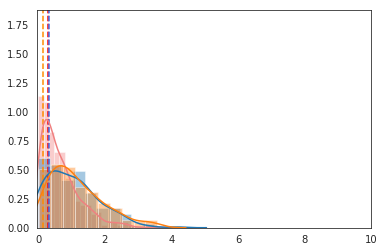

In [60]:
pvals_t_test3=pvals_t_test
pvals_sep_logR3=pvals_sep_logR
pvals3=pvals

plt.figure()
pvals_t_test_gene3=pvals_t_test_gene
pvals_logr_gene3=pvals_logr_gene
# sns.distplot(-np.log10(pvals_t_test_gene3),hist=True,color='r')
sns.distplot(-np.log10(pvals_t_test_gene3),hist=True,color='lightcoral',)

sns.distplot(-np.log10(pvals_sep_logR3))
sns.distplot(-np.log10(pvals3))
# sns.distplot(-np.log10(pvals_t_test3),hist=False,color='k')


yy=ax.get_ylim()
plt.vlines(-np.log10(bB3[1]),ymin=yy[0],ymax=yy[1],color='r',linestyles='--')
plt.vlines(-np.log10(cC3[1]),ymin=yy[0],ymax=yy[1],color='royalblue',linestyles='--')
plt.vlines(-np.log10(aA3[1]),ymin=yy[0],ymax=yy[1],color='darkorange',linestyles='--')

plt.ylim(yy)
plt.xlim([-0.05,10])

plt.show()